In [10]:
import glob, cv2
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from vidio.read import OpenCVReader
import multicam_calibration as mcc
from multicam_calibration.detection import _generate_chessboard_anchor_template
from pathlib import Path

## Look for the calibration files

/Users/vigji/Desktop/rig _test_videos/checkerboard0_cropped/checkerboard0_mirror_right.avi


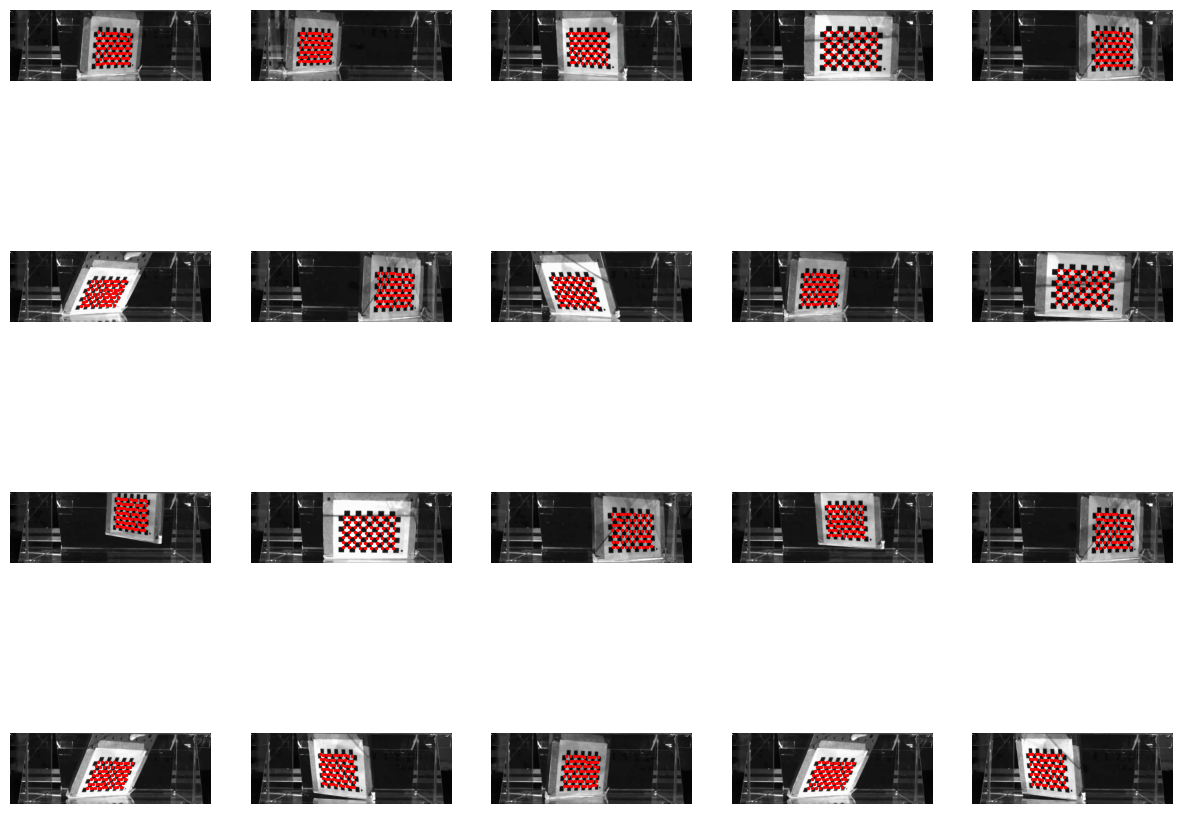

In [50]:
import h5py
from bonpy import OpenCVMovieData

video_dir = Path('/Users/vigji/Desktop/rig _test_videos/checkerboard0_cropped')
video_path = [f for f  in video_dir.glob('*.avi')][3]
print(video_path)
save_path = video_path.parent / (video_path.stem + ".detections.h5")

with h5py.File(save_path, "r") as h5:
    uvs = h5["uvs"][:]
    img_sizes = h5["img_size"][:]
    frame_ixs = h5["frame_ixs"][:]

movie_data = OpenCVMovieData(video_path)

# plot a random sample of 20 detections in a grid:

n = 20
ixs = np.random.choice(len(uvs), n, replace=False)

fig, axs = plt.subplots(4, 5, figsize=(15, 12))
axs = axs.ravel()

for i, ix in enumerate(ixs):
    img = movie_data[frame_ixs[ix]]
    ax = axs[i]
    ax.imshow(img, cmap='gray')
    ax.scatter(uvs[ix, :, 0], uvs[ix, :, 1], c='r', s=2)
    ax.axis('off')

In [62]:
def load_all_detected(video_path):
    video_path = Path(video_path)
    video_paths = video_path.glob("*.avi")
    qc_datas = []
    for video_path in video_paths:
        detections_path = video_path.parent / f"{video_path.stem}.detections.h5"
        assert video_path.exists(), (
            f"Could not find {detections_path}. "
            "Run `run_calibration_detection` first."
        )
        with h5py.File(detections_path, "r") as h5:
            qc_datas.append(h5["qc_data"][:]) 

    return qc_datas

In [64]:
data = load_all_detected("/Users/vigji/Desktop/rig _test_videos/checkerboard0_cropped")

In [69]:
data[0]

array([[-0.12980741, -0.45268831, -0.57543847, -0.60560668],
       [-0.15927057, -0.47334218, -0.50769945, -0.61987069],
       [-0.19878943, -0.43360006, -0.462539  , -0.631128  ],
       ...,
       [-0.22382838, -0.42931459, -0.58275161, -0.62045092],
       [-0.23428211, -0.44310954, -0.56395163, -0.63282281],
       [-0.09482034, -0.44055584, -0.46947097, -0.57203197]])

## Copypaste from docs

In [24]:
board_shape = (5,7)
square_size = 10

# camera_names = ['top.24562653', 'side1.24548223', 'side2.24535649', 
 #                'side4.24535665', 'side3.24562655', 'bottom.24562650']

video_dir = Path('/Users/vigji/Desktop/134838_latest_calibration/checkerboard_cropped')
video_paths = [str(f) for f  in video_dir.glob('*.avi')]

# detect calibration object in each video
all_calib_uvs, all_img_sizes = mcc.run_calibration_detection(
    video_paths, mcc.detect_chessboard, n_workers=6,
    detection_options=dict(board_shape=board_shape, scale_factor=0.5))

# display a table with the detections shared between camera pairs
mcc.summarize_detections(all_calib_uvs)

# plot corner-match scores for each frame
# fig = mcc.plot_chessboard_qc_data(video_paths)

# optionally generate overlay videos
# for p in video_paths:
#     mcc.overlay_detections(p)


,Camera 0,Camera 1,Camera 2,Camera 3,Camera 4
Camera 0,7820,7262,3701,2594,3757
Camera 1,7262,8369,4065,2736,4025
Camera 2,3701,4065,7229,2098,6259
Camera 3,2594,2736,2098,4961,2281
Camera 4,3757,4025,6259,2281,7335


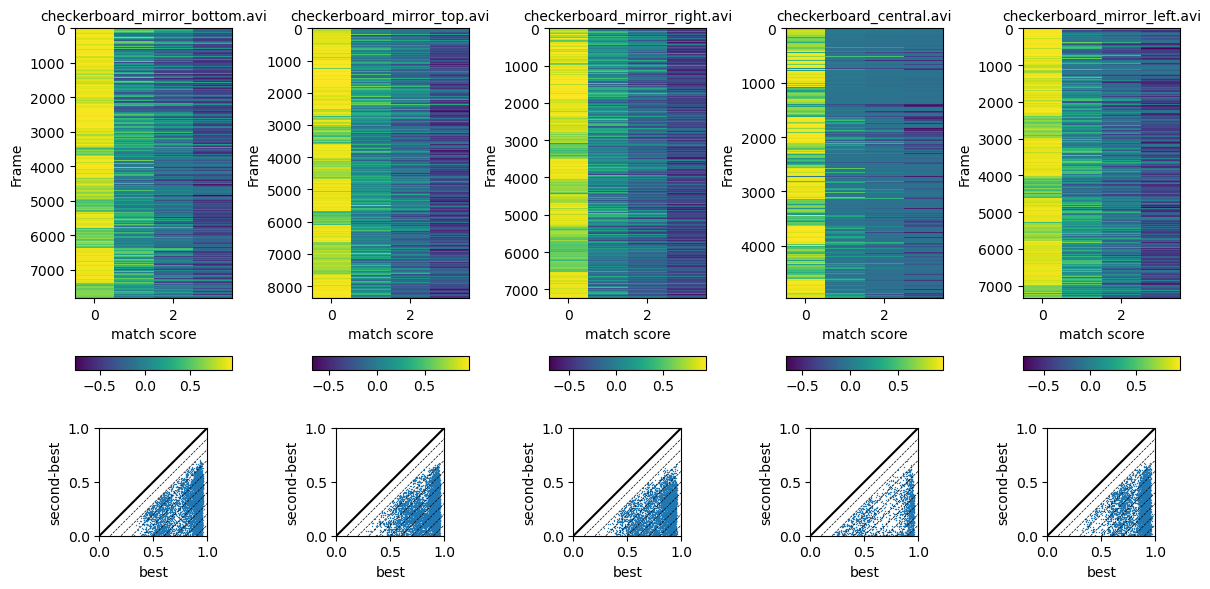

In [25]:
fig = mcc.plot_chessboard_qc_data(video_paths)

In [26]:
calib_objpoints = mcc.generate_chessboard_objpoints(board_shape, square_size)

all_extrinsics, all_intrinsics, calib_poses = mcc.calibrate(
    all_calib_uvs, all_img_sizes, calib_objpoints, root=0, n_samples_for_intrinsics=100)

Estimating camera intrinsics


100%|█████████████████████████████████████| 5/5 [00:15<00:00,  3.02s/it]


Initializing calibration object poses


100%|█████████████████████████████████████| 5/5 [00:04<00:00,  1.18it/s]


Estimating camera extrinsics
Merging calibration object poses


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


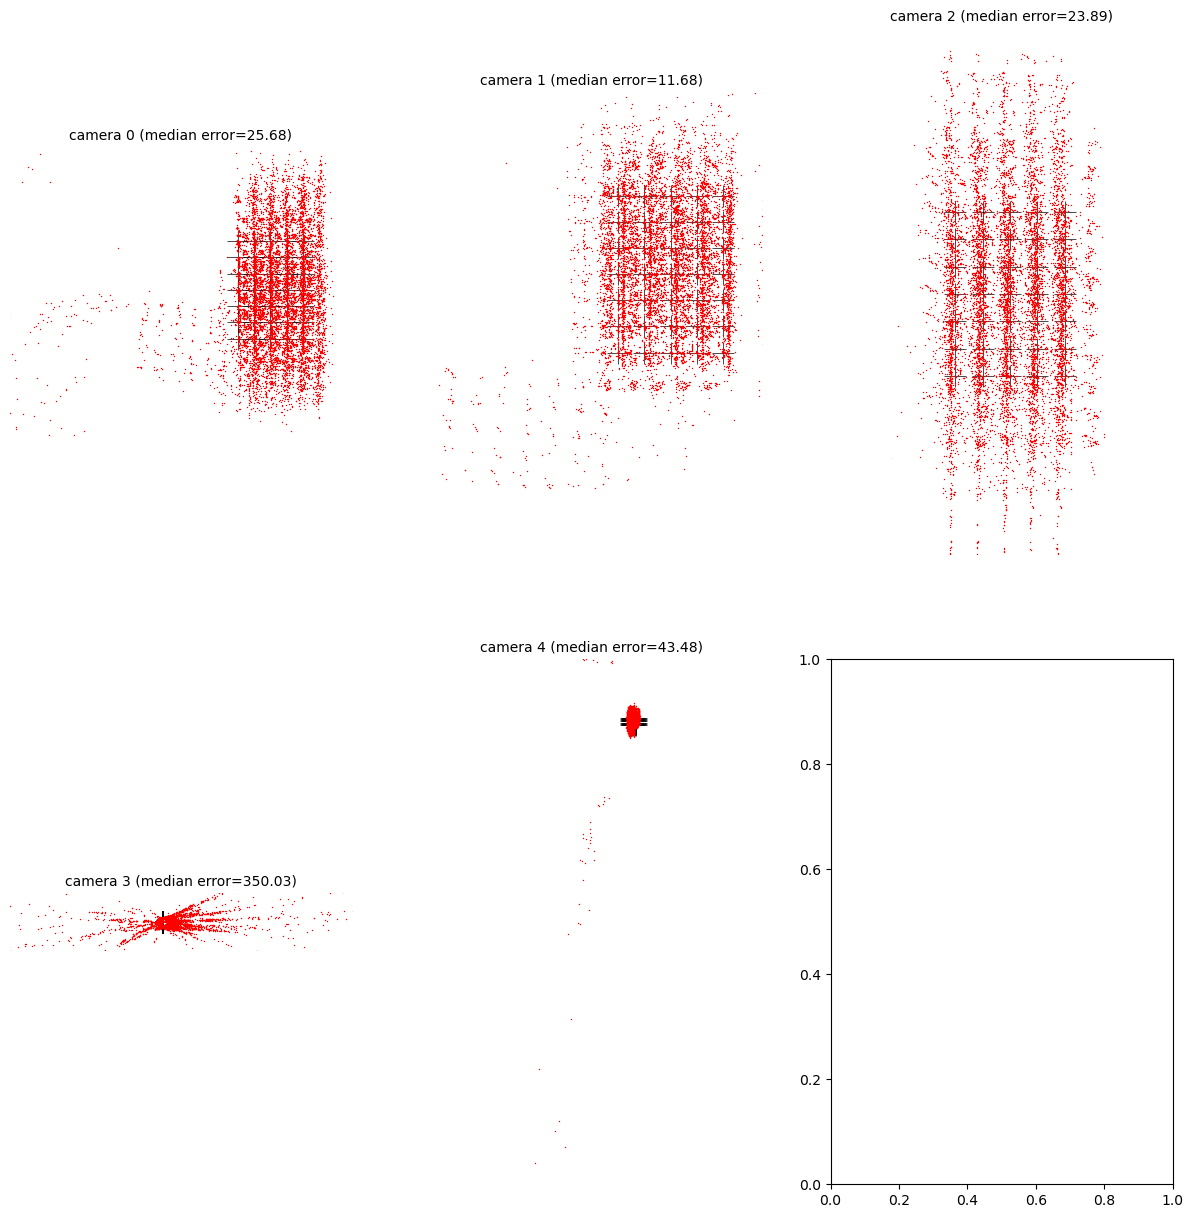

In [27]:
fig, mean_squared_error, reprojections, transformed_reprojections = mcc.plot_residuals(
    all_calib_uvs, all_extrinsics, all_intrinsics, calib_objpoints, calib_poses)

In [28]:
adj_extrinsics, adj_intrinsics, adj_calib_poses, use_frames, result = \
    mcc.bundle_adjust(all_calib_uvs, all_extrinsics, all_intrinsics, calib_objpoints, calib_poses, n_frames=5000, ftol=1e-4)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.8504e+07                                    1.48e+08    
       1             10         3.4701e+07      2.38e+07       1.14e+03       1.48e+08    
       2             11         3.3835e+07      8.66e+05       2.29e+03       1.48e+08    
       3             13         3.3573e+07      2.62e+05       2.87e+02       1.48e+08    
       4             14         3.3147e+07      4.26e+05       9.50e+02       1.48e+08    
       5             15         3.2453e+07      6.94e+05       2.31e+02       1.48e+08    
       6             16         3.1645e+07      8.08e+05       4.78e+02       1.46e+08    
       7             17         3.0404e+07      1.24e+06       6.98e+02       1.43e+08    
       8             18         2.8629e+07      1.78e+06       8.56e+02       1.33e+08    
       9             19         2.6297e+07      2.33e+06       9.55e+02       1.15e+08    

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:01<00:00,  4.15it/s]


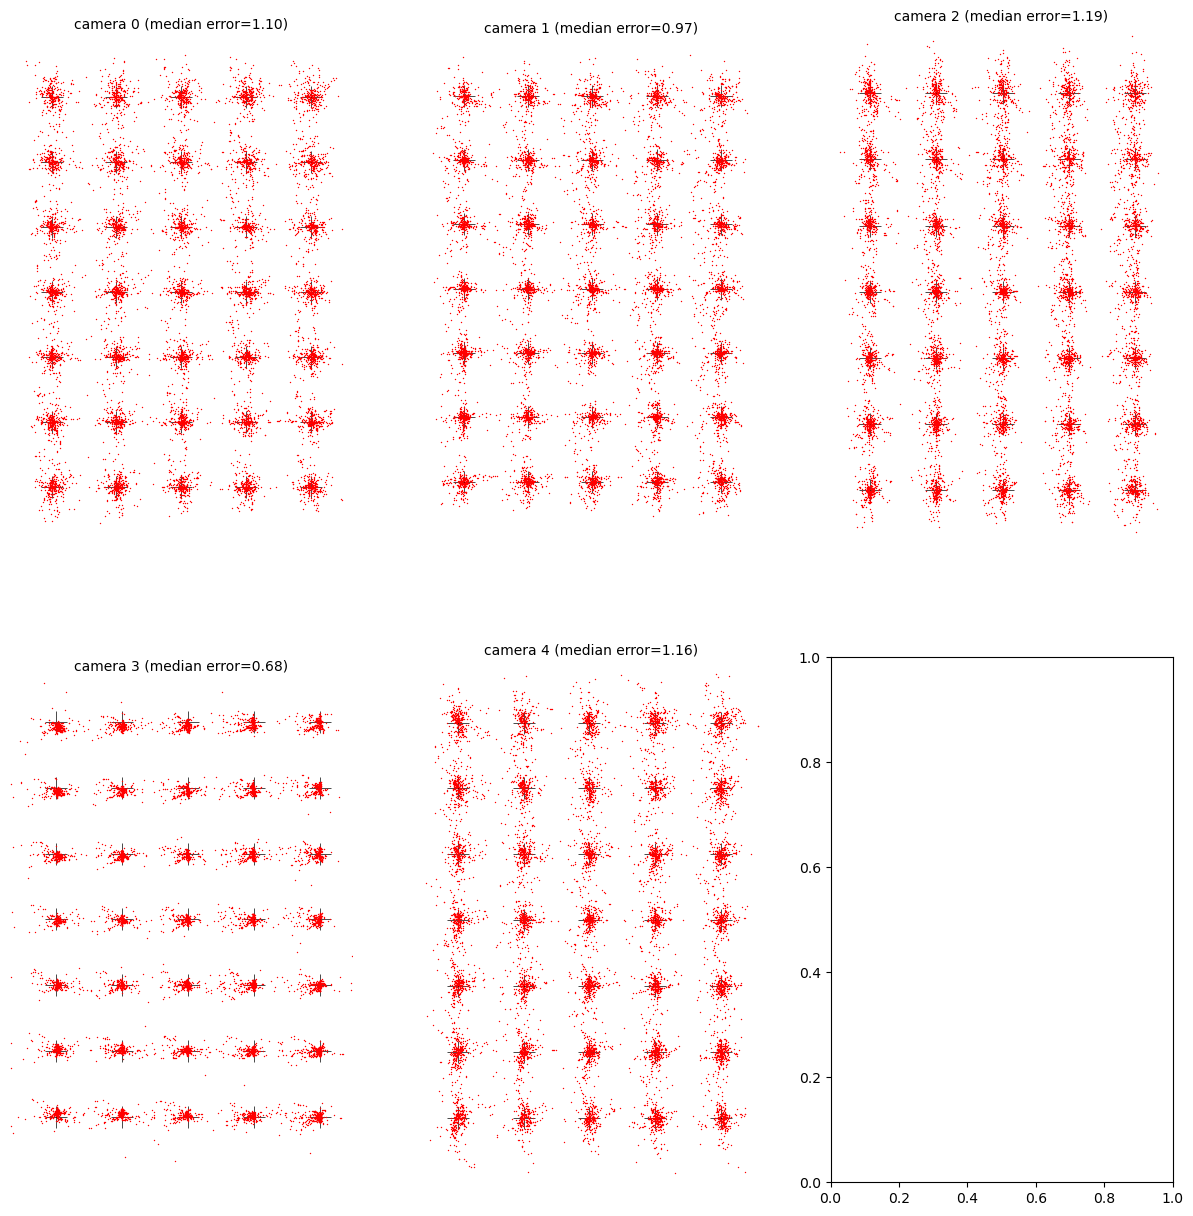

In [31]:
fig, median_error, reprojections, transformed_reprojections = mcc.plot_residuals(
    all_calib_uvs[:,use_frames], adj_extrinsics, adj_intrinsics, calib_objpoints, adj_calib_poses)

In [30]:
a = 1